In [1]:
import json
import pandas as pd
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

def evaluate_and_plot_mlp(
    model_path: str,
    norms_json: str,
    hidden_dims: list[int],
    activations: list[str],
    test_csv: str,
    sample_index: int = None
):
    """
    Load a trained MLP (excluding Input 12), apply saved normalization constants,
    evaluate on test data, compute R^2, and plot:
      1) Error histogram
      2) True vs Predicted scatter (optional highlight of one sample)
    """

    # 0) Load saved norms
    with open(norms_json, 'r') as f:
        norms = json.load(f)
    y_mean, y_std = norms['y_mean'], norms['y_std']
    feat_mean, feat_std = norms['feat_mean'], norms['feat_std']

    # 1) Load & preprocess test data
    df = pd.read_csv(test_csv)
    for c in ("F2","F3"):
        if c in df: df.drop(columns=[c], inplace=True)
    y_true = df["Output"].to_numpy(dtype=float)

    # build feature matrix X = Inputs 1–18 except 12
    all_inputs = [f"Input {i}" for i in range(1,19) if i != 12]
    X = df[all_inputs].copy()

    # encode Inputs 1–8
    categories_map = {
      'Input 1':[1,2], 'Input 2':list(range(1,6)), 'Input 3':list(range(1,6)),
      'Input 4':list(range(1,22)), 'Input 5':list(range(1,6)),
      'Input 6':[1,2,3], 'Input 7':[1,2,3,4], 'Input 8':list(range(1,11))
    }
    for col, cats in categories_map.items():
        if col not in X: continue
        if len(cats) == 2:
            X[col] = X[col].map({cats[0]: +1.0, cats[1]: -1.0})
        else:
            X[col] = pd.Categorical(X[col], categories=cats)
            dummies = pd.get_dummies(X[col], prefix=col)
            for c in cats:
                key = f"{col}_{c}"
                if key not in dummies: dummies[key] = 0
            X = pd.concat([X.drop(columns=[col]), dummies], axis=1)

    # normalize numeric Inputs 9–18 except 12 using loaded norms
    numeric_inputs = [f"Input {i}" for i in range(9,19) if i != 12]
    for col in numeric_inputs:
        X[col] = (X[col] - feat_mean[col]) / feat_std[col]

    X_np = X.to_numpy(dtype=np.float32)

    # 2) Define MLP architecture
    class MLPNet(nn.Module):
        def __init__(self, in_dim, hidden_dims, activations):
            super().__init__()
            layers = []
            dims = [in_dim] + hidden_dims
            for i, h in enumerate(hidden_dims):
                layers.append(nn.Linear(dims[i], dims[i+1]))
                act = activations[i].lower()
                if act == 'relu':
                    layers.append(nn.ReLU())
                elif act == 'tanh':
                    layers.append(nn.Tanh())
                elif act == 'sigmoid':
                    layers.append(nn.Sigmoid())
                elif act == 'softplus':
                    layers.append(nn.Softplus())
                else:
                    raise ValueError(f"Unknown activation '{activations[i]}'")
            layers.append(nn.Linear(dims[-1], 1))
            self.net = nn.Sequential(*layers)

        def forward(self, x):
            return self.net(x)

    # 3) Load model
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = MLPNet(X_np.shape[1], hidden_dims, activations).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # 4) Predict
    with torch.no_grad():
        X_t = torch.from_numpy(X_np).to(device)
        y_pred_norm = model(X_t).cpu().numpy().flatten()
    y_pred = y_pred_norm * y_std + y_mean

    # ─── New: Compute and print R^2 ───────────────────────────────────────────────
    mean_true = np.mean(y_true)
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - mean_true) ** 2)
    r2 = 1 - ss_res / ss_tot
    print(f"R² (coefficient of determination): {r2:.4f}")
    # ──────────────────────────────────────────────────────────────────────────────

    # 5) Error histogram
    plt.figure(figsize=(8,5))
    plt.hist(y_pred - y_true, bins=30, edgecolor='k')
    plt.title("Prediction Error Histogram")
    plt.xlabel("Predicted − True")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    # 6) True vs Predicted scatter
    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, alpha=0.6, label='All samples')
    mn, mx = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())
    plt.plot([mn, mx], [mn, mx], 'k--', label='45° line')
    if sample_index is not None and 0 <= sample_index < len(y_true):
        plt.scatter(
            [y_true[sample_index]],
            [y_pred[sample_index]],
            color='red', s=80,
            label=f"Sample {sample_index}"
        )
    plt.title("True vs Predicted")
    plt.xlabel("True Output")
    plt.ylabel("Predicted Output")
    plt.legend()
    plt.tight_layout()
    plt.show()


R² (coefficient of determination): 0.8307


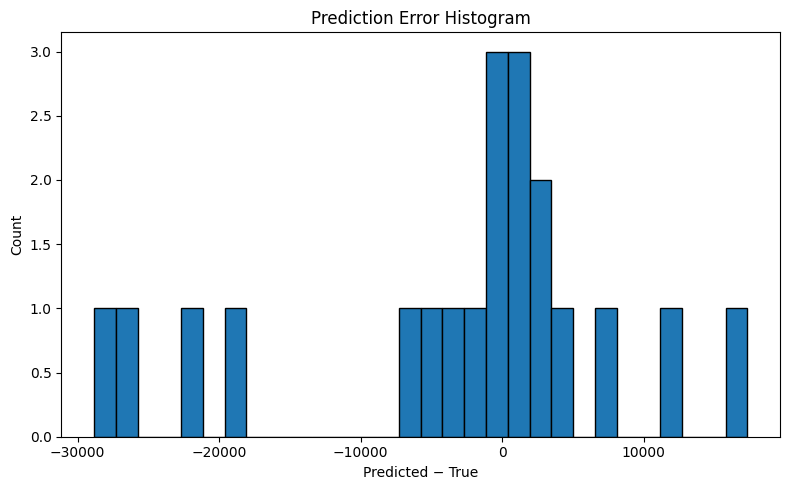

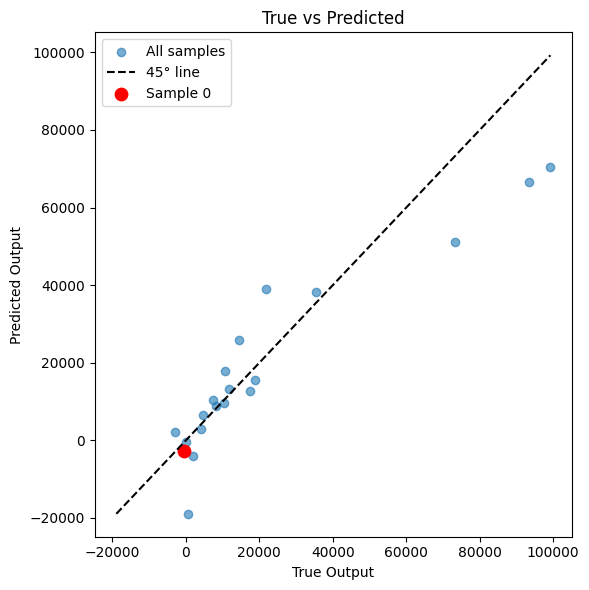

In [2]:
evaluate_and_plot_mlp(
    model_path="/home/kamiar/chevron/Acid-neural-net/First Data-V3/58c0fccc/58c0fccc_fold4.pth",
    norms_json="/home/kamiar/chevron/Acid-neural-net/First Data-V3/58c0fccc/58c0fccc_norms.json",
    hidden_dims=[4,4],
    activations=['softplus','softplus'],
    test_csv="/home/kamiar/chevron/Acid-neural-net/First Data-V3/data/test.csv",
    sample_index=0    # or None to skip highlighting
)
